# Random Data as Input
Having a range of data, given the limits of position and velocity, generate uniform random data using the made up library of functions

In [72]:
import integrate_data as intd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import torch

In [73]:
#input of global program (data about our network)
N_layers = 300
dt = 5e-2
name = "exp_random_data"
relative_tolerance = 1e-3


#comparission for post processing
xreal, epsilon = 4.0, 5e-1

# function for the differential equation
alpha = 1
def force_function(x):
    # return - alpha * x * x
    # return (1/8000)*((x-1) * (x-11)**2 * (x-23)**2) - 0.7
    return -x*x*x + 3 + np.cos(x)
    

In [74]:
# ========== input specific to random generation progam ==========
xlow, xhigh = -10.0, 20.0
vlow, vhigh = -5.0, 5.0
N_samples = 1000

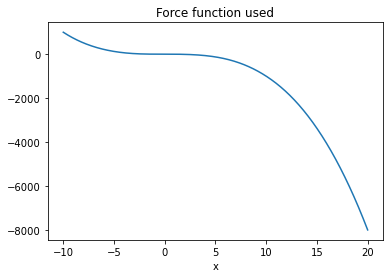

In [75]:
# ===== inner definitions of the program ==================
xlimits = [xlow, xhigh]
vlimits = [vlow, vhigh]
# the first tuple is low limits for both
limits = list(zip(xlimits, vlimits))


# where we save the data information
global_data = []

#starting the generation of random data
random_xv = np.random.uniform(low=limits[0], high=limits[1], 
    size=(N_samples,2))


# defining the function for simulation
def f_dottz(t, z):
    """function in the differential equation"""
    x, v = z
    dzdt = [v, force_function(x)]
    return dzdt

# plot of force function
x_plot = np.linspace(xlow, xhigh, 400)
plt.plot(x_plot, force_function(x_plot))
plt.title("Force function used")
plt.xlabel('x')
plt.show()

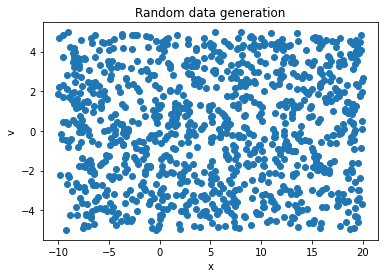

In [76]:
# plotting of the distribution
plt.scatter(random_xv[:,0], random_xv[:,1])
plt.xlabel('x')
plt.ylabel('v')
plt.title("Random data generation")
plt.show()

In [77]:
# ====== Generation of data ================
for k_data in range(N_samples):
    # generate the series with the inputs
    xi = random_xv[k_data][0]
    vi = random_xv[k_data][1]

    arguments = intd.make_integrator_args(name,xi,vi,N_layers, dt)

    try:
        data_id, sol_estatus, data_generated = intd.run_integrator(
            arguments, vec_function=f_dottz, relative_tolerance=relative_tolerance)
        # we use the last data point
        data_point = [xi,vi,data_generated[-1][1], data_generated[-1][2] ]

    except ValueError:
        data_point = [xi, vi, np.nan, np.nan]

    global_data.append(data_point)

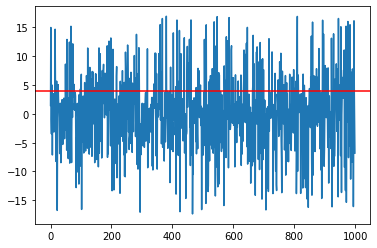

In [78]:
total_data_frame = pd.DataFrame(global_data, columns=["xi", "vi", "xf", "vf"])
total_data_frame.head()

plt.plot(total_data_frame.xf)
plt.axhline(y=xreal, color='r', linestyle='-')
plt.show()

now to this data frame we add a column that checks 3 possible conditions:
- `K=0` if `xf` close to `xreal` given `epsilon`
- `K=-1` if `xf` is `NaN`
- `K=1` any other case


In [79]:
epsilon = 2
# apply K
total_data_frame["K"] = total_data_frame.apply(
    lambda row: 0 if abs(row["xf"] - xreal) <= epsilon else 
                -1 if np.isnan(row["xf"]) else 1,
    axis=1
)

# data in the range where xf is close to xreal (normally set to 0)
print(f"Total positive data K=0: {sum(total_data_frame['K'] == 0)} data points")


Total positive data K=0: 184 data points


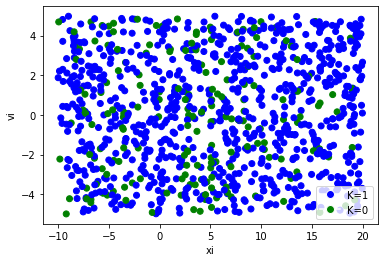

In [80]:
# define colors for each value of K
colors = {-1: 'red', 0: 'green', 1: 'blue'}
labels = {-1: 'K=-1', 0: 'K=0', 1: 'K=1'}


# create a scatter plot with xi and vi as x and y axes, and color the points according to K
plt.scatter(total_data_frame['xi'], total_data_frame['vi'], 
    c=total_data_frame['K'].apply(lambda x: colors[x]),
    label=total_data_frame['K'].apply(lambda x: labels[x]))

# add axis labels
plt.xlabel('xi')
plt.ylabel('vi')
# gives only the unique
legend_elements = [(labels[x], colors[x]) for x in total_data_frame['K'].unique()]
plt.legend(handles=[plt.Line2D([], [], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in legend_elements], loc='best')



# show the plot
plt.show()

### Maping as 3D distance -> K continuous


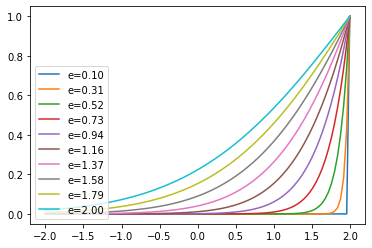

In [81]:
x = np.linspace(-2,2,100)
def narrow_gaussian(x, mu=0, sigma=0.01):
    pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return pdf / pdf.max()

for epsilon_plot in np.linspace(0.1, 2, 10):
    plt.plot(x, narrow_gaussian(x, mu=xreal, sigma=epsilon_plot), label=f"e={epsilon_plot :.2f}")
    
plt.legend(loc='lower left')

In [82]:
total_data_frame['c_K'] = narrow_gaussian(total_data_frame['xf'], sigma=1)
total_data_frame['c_K'] = total_data_frame['c_K'].fillna(-1)

total_data_frame[['xf', 'K', 'c_K']]

,xf,K,c_K
0,1.475323,1,3.367927e-01
1,14.999394,1,1.399002e-49
2,-0.973626,1,6.225242e-01
3,-3.472860,1,2.404586e-03
4,5.039451,0,3.057127e-06
...,...,...,...
995,-4.060896,1,2.624534e-04
996,16.158039,1,2.026367e-57
997,3.716313,0,1.002268e-03
998,-2.695677,1,2.642784e-02


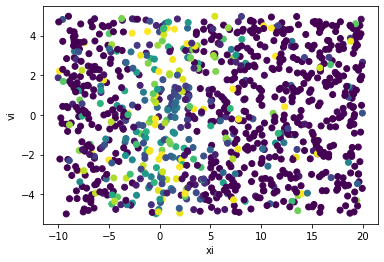

In [83]:
# create a scatter plot with xi and vi as x and y axes, and color the points according to K
plt.scatter(total_data_frame['xi'], total_data_frame['vi'], c=total_data_frame['c_K'][:len(total_data_frame['xi'])])

# add axis labels
plt.xlabel('xi')
plt.ylabel('vi')
# gives only the unique
# show the plot
plt.show()

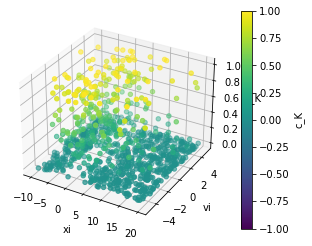

In [84]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors


cmap = 'viridis'
#cmap = colors.ListedColormap(['red', 'green', 'blue'])
norm = colors.Normalize(vmin=-1, vmax=1)


# define colors for each value of c_K
# colors = {-1: 'red', 0: 'green', 1: 'blue'}

# create a 3D scatter plot with xi, vi, and c_K as x, y, and z axes, and color the points according to c_K
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(total_data_frame['xi'], total_data_frame['vi'], total_data_frame['c_K'], c=total_data_frame['c_K'], cmap=cmap, norm=norm)

# add axis labels
ax.set_xlabel('xi')
ax.set_ylabel('vi')
ax.set_zlabel('c_K')

# add a colorbar to show the color gradient
cbar = plt.colorbar(ax.collections[0])
cbar.set_label('c_K')
plt.show()